Ideal student-teacher ratio across Texas districts

In [1]:
## Project 4
import pandas as pd
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from pymongo import MongoClient

In [2]:
mongo = MongoClient(port=27017)

In [3]:
for dbname in mongo.list_database_names():
    if dbname == "texasSchoolsDB":
        print(f'{dbname} <----------')
    else:
        print(dbname)

admin
classDB
config
dbName
fruits_db
local
met
texasSchoolsDB <----------
travel_db
uk_food


In [4]:
db = mongo["texasSchoolsDB"]

In [5]:

collection = db['teachers20_21']

In [6]:
teacher20_21_df = pd.DataFrame(list(collection.find()))

teacher20_21_df.drop(columns=['_id'], inplace=True, errors='ignore')

teacher20_21_df.head()

,DISTRICT NAME,TOTAL NUMBER OF SCHOOLS,TOTAL STUDENTS,TOTAL STAFF FTE,TOTAL TEACHER FTE,STAFF: % TEACHERS,STAFF: % EDUCATIONAL AIDES,STAFF: % AUXILIARY,AVERAGE SALARY: TEACHER,NUMBER OF STUDENTS PER TOTAL STAFF,...,TEACHER: % CAREER & TECHNICAL EDUCATION,TEACHER: % OTHER EDUCATION (INCLUDES G & T),ATTENDANCE RATE (2020-21),ANNUAL DROPOUT RATE GR,4-YR LONGITUDINAL GRADUATION RATE (CLASS OF 2021) DISTRICT EXCL,5-YR LONGITUDINAL GRADUATION RATE (CLASS OF 2020) DISTRICT EXCL,ANNUAL GRADUATE COUNT (2020-21),COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020-2021),SAT-AVERAGE SCORE (2021-2020),ACT-AVERAGE SCORE (2021-2020)
0,CAYUGA ISD,3,574,99.9,46.7,46.8,14.8,26.5,55570.0,5.7,...,8.5,0.0,96.7,{' 9-12 (2020-21)': 0},100.0,100.0,36.0,19.0,980.0,NaN
1,ELKHART ISD,4,1150,186.6,104.9,56.2,16.2,19.5,47916.0,6.2,...,13.0,1.5,96.0,{' 9-12 (2020-21)': 0.3},100.0,98.9,91.0,27.7,979.0,-1.0
2,FRANKSTON ISD,3,808,146.7,74.5,50.8,15.0,27.4,50382.0,5.5,...,2.2,0.0,95.4,{' 9-12 (2020-21)': 0.4},95.2,100.0,41.0,36.8,980.0,-1.0
3,NECHES ISD,2,342,60.1,30.2,50.3,13.7,26.2,55346.0,5.7,...,10.8,1.7,95.8,{' 9-12 (2020-21)': 0},95.8,97.0,23.0,15.0,1007.0,18.8
4,PALESTINE ISD,6,3360,553.4,260.3,47.0,19.7,19.5,48825.0,6.1,...,9.0,1.8,93.7,{' 9-12 (2020-21)': 0},99.0,99.6,201.0,49.4,1048.0,21.0


Project Overview
* Goal: Develop a predictive model for the ideal student-teacher ratio.
* Data: District-wise information from Texas.
* Metrics: To evaluate our model, we'll consider accuracy measures like MAE (Mean Absolute Error), RMSE (Root Mean Square Error), and R² (Coefficient of Determination).

In [7]:
# Check for missing values
print(teacher20_21_df.isnull().sum())

DISTRICT NAME                                                        0
TOTAL NUMBER OF SCHOOLS                                              0
TOTAL STUDENTS                                                       0
TOTAL STAFF FTE                                                      3
TOTAL TEACHER FTE                                                    3
STAFF: % TEACHERS                                                    3
STAFF: % EDUCATIONAL AIDES                                           3
STAFF: % AUXILIARY                                                   3
AVERAGE SALARY: TEACHER                                              4
NUMBER OF STUDENTS PER TOTAL STAFF                                   3
NUMBER OF STUDENTS PER TEACHER                                       3
TEACHER: % WITH 5 OR FEWER YEARS OF EXPERIENCE                       3
TEACHER: AVERAGE YEARS OF EXPERIENCE                                 3
TEACHER: % WITH ADVANCED DEGREES                                     3
TEACHE

In [8]:
from sklearn.impute import SimpleImputer

# Imputer for numeric columns
numeric_imputer = SimpleImputer(strategy='mean')
# List of numeric columns with minimal missing values
numeric_columns_minimal_missing = ['TOTAL STAFF FTE', 'TOTAL TEACHER FTE', 'AVERAGE SALARY: TEACHER']

teacher20_21_df[numeric_columns_minimal_missing] = numeric_imputer.fit_transform(teacher20_21_df[numeric_columns_minimal_missing])

# If any of the columns with minimal missing values are categorical, use mode imputation similarly.


In [9]:
# Example: Imputation for a column with many missing values
# Let's use median for these to avoid the influence of outliers
substantial_missing_imputer = SimpleImputer(strategy='median')
teacher20_21_df[['COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020-2021)', 'SAT-AVERAGE SCORE (2021-2020)', 'ACT-AVERAGE SCORE (2021-2020)']] = substantial_missing_imputer.fit_transform(teacher20_21_df[['COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020-2021)', 'SAT-AVERAGE SCORE (2021-2020)', 'ACT-AVERAGE SCORE (2021-2020)']])


In [10]:
for column in ['COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020-2021)', 'SAT-AVERAGE SCORE (2021-2020)', 'ACT-AVERAGE SCORE (2021-2020)']:
    teacher20_21_df[column + '_missing'] = teacher20_21_df[column].isnull().astype(int)

In [11]:
teacher20_21_df.columns

Index(['DISTRICT NAME', 'TOTAL NUMBER OF SCHOOLS', 'TOTAL STUDENTS',
       'TOTAL STAFF FTE', 'TOTAL TEACHER FTE', 'STAFF: % TEACHERS',
       'STAFF: % EDUCATIONAL AIDES', 'STAFF: % AUXILIARY',
       'AVERAGE SALARY: TEACHER', 'NUMBER OF STUDENTS PER TOTAL STAFF',
       'NUMBER OF STUDENTS PER TEACHER',
       'TEACHER: % WITH 5 OR FEWER YEARS OF EXPERIENCE',
       'TEACHER: AVERAGE YEARS OF EXPERIENCE',
       'TEACHER: % WITH ADVANCED DEGREES', 'TEACHER: % AFRICAN AMERICAN',
       'TEACHER: % HISPANIC', 'TEACHER: % WHITE', 'TEACHER: % AMERICAN INDIAN',
       'TEACHER: % ASIAN', 'TEACHER: % PACIFIC ISLANDER',
       'TEACHER: % TWO OR MORE RACES', 'TEACHER: % REGULAR EDUCATION',
       'TEACHER: % SPECIAL EDUCATION', 'TEACHER: % COMPENSATORY EDUCATION',
       'TEACHER: % BILINGUAL/ESL EDUCATION',
       'TEACHER: % CAREER & TECHNICAL EDUCATION',
       'TEACHER: % OTHER EDUCATION (INCLUDES G & T)',
       'ATTENDANCE RATE (2020-21)', 'ANNUAL DROPOUT RATE GR',
       '4-YR LONG

Idea> 1. Proportion of Teachers with Advanced Degrees
A higher percentage of teachers with advanced degrees might correlate with a different optimal student-teacher ratio, potentially reflecting on the quality of education.

Idea> 2. Experience Level
The average years of experience among teachers and the percentage of teachers with 5 or fewer years of experience could be crucial. These could affect the ideal ratio, as more experienced teachers might manage larger classes more effectively.

Idea> 3. 3. Teacher Diversity
Diversity in the teaching staff, represented by the percentage of teachers from various racial backgrounds, could be an important factor, possibly affecting student engagement and the learning environment.

Idea> 4. Specialization in Education
The percentage of teachers in specialized roles (Special Education, Bilingual/ESL Education, etc.) might influence the ideal student-teacher ratio, as these roles often require more individualized attention to students.

Idea> 5. 5. Financial Aspects
The average salary of a teacher could be a proxy for district investment in education, which might relate to the optimal student-teacher ratio.

In [12]:

# Creating column current student/teacher ratio
if 'TOTAL STUDENTS' in teacher20_21_df.columns and 'TOTAL TEACHER FTE' in teacher20_21_df.columns:
    # Calculate the current student-teacher ratio
    teacher20_21_df['current_student_teacher_ratio'] = teacher20_21_df['TOTAL STUDENTS'] / teacher20_21_df['TOTAL TEACHER FTE']
    print("The 'current_student_teacher_ratio' feature has been successfully added to the dataset.")
else:
    print("Error: Required columns ('TOTAL STUDENTS' and/or 'TOTAL TEACHER FTE') are missing from the dataset.")

# Display the first few rows to verify the new column
print(teacher20_21_df[['TOTAL STUDENTS', 'TOTAL TEACHER FTE', 'current_student_teacher_ratio']].head())


The 'current_student_teacher_ratio' feature has been successfully added to the dataset.
   TOTAL STUDENTS  TOTAL TEACHER FTE  current_student_teacher_ratio
0             574               46.7                      12.291221
1            1150              104.9                      10.962822
2             808               74.5                      10.845638
3             342               30.2                      11.324503
4            3360              260.3                      12.908183


In [13]:
teacher20_21_df.columns

Index(['DISTRICT NAME', 'TOTAL NUMBER OF SCHOOLS', 'TOTAL STUDENTS',
       'TOTAL STAFF FTE', 'TOTAL TEACHER FTE', 'STAFF: % TEACHERS',
       'STAFF: % EDUCATIONAL AIDES', 'STAFF: % AUXILIARY',
       'AVERAGE SALARY: TEACHER', 'NUMBER OF STUDENTS PER TOTAL STAFF',
       'NUMBER OF STUDENTS PER TEACHER',
       'TEACHER: % WITH 5 OR FEWER YEARS OF EXPERIENCE',
       'TEACHER: AVERAGE YEARS OF EXPERIENCE',
       'TEACHER: % WITH ADVANCED DEGREES', 'TEACHER: % AFRICAN AMERICAN',
       'TEACHER: % HISPANIC', 'TEACHER: % WHITE', 'TEACHER: % AMERICAN INDIAN',
       'TEACHER: % ASIAN', 'TEACHER: % PACIFIC ISLANDER',
       'TEACHER: % TWO OR MORE RACES', 'TEACHER: % REGULAR EDUCATION',
       'TEACHER: % SPECIAL EDUCATION', 'TEACHER: % COMPENSATORY EDUCATION',
       'TEACHER: % BILINGUAL/ESL EDUCATION',
       'TEACHER: % CAREER & TECHNICAL EDUCATION',
       'TEACHER: % OTHER EDUCATION (INCLUDES G & T)',
       'ATTENDANCE RATE (2020-21)', 'ANNUAL DROPOUT RATE GR',
       '4-YR LONG

For starters, we'll explore a few regression models to see which performs best on the dataset:

Linear Regression: A good baseline that's easy to interpret.
Random Forest Regressor: A powerful model that can capture complex nonlinear relationships.
Gradient Boosting Regressor: Another robust model known for its predictive accuracy.

X = 'TOTAL NUMBER OF SCHOOLS': More schools could indicate a larger district with potentially different staffing needs.

'TOTAL STUDENTS': Directly impacts the student-teacher ratio.

'TOTAL TEACHER FTE': Essential for calculating the student-teacher ratio.

'STAFF: % TEACHERS', 'STAFF: % EDUCATIONAL AIDES', and 'STAFF: % AUXILIARY': These percentages provide insight into the composition of the staff, which could affect the ideal ratio.

'AVERAGE SALARY: TEACHER': Higher salaries might attract more qualified or experienced teachers, potentially affecting the ideal ratio.

'TEACHER: % WITH ADVANCED DEGREES' and 'TEACHER: AVERAGE YEARS OF EXPERIENCE': Qualifications and experience of teachers could influence the optimal student-teacher ratio.

'TEACHER: % WITH 5 OR FEWER YEARS OF EXPERIENCE': This might indicate a younger, less experienced workforce, possibly affecting the ideal ratio differently.

Demographic percentages ('TEACHER: % AFRICAN AMERICAN', 'TEACHER: % HISPANIC', etc.): While not directly affecting the student-teacher ratio, these features might be relevant in broader analyses related to diversity and educational equity.


In [14]:


# Check if any division might lead to infinity
teacher20_21_df['current_student_teacher_ratio'] = teacher20_21_df['TOTAL STUDENTS'] / teacher20_21_df['TOTAL TEACHER FTE'].replace(0, np.nan)

# For 'normalized_teacher_salary', ensure the normalization process didn't introduce any infinity
# Assuming 'normalized_teacher_salary' is already in your DataFrame, no division by zero should occur in normalization
# However, let's ensure no infinite values are present
teacher20_21_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Now, handle NaN values (which might include what were infinities)
teacher20_21_df.dropna(subset=['current_student_teacher_ratio'], inplace=True)


Finding best column to include in X

In [15]:
# Select only numeric columns for correlation analysis
numeric_data = teacher20_21_df.select_dtypes(include=['number'])

# Now, calculate the correlation matrix on this numeric subset
correlation_matrix = numeric_data.corr()

# Extract and sort the correlations with 'current_student_teacher_ratio'
correlation_with_target = correlation_matrix['current_student_teacher_ratio'].sort_values(ascending=False)

print("Correlation with 'current_student_teacher_ratio':")
print(correlation_with_target)



Correlation with 'current_student_teacher_ratio':
current_student_teacher_ratio                                      1.000000
NUMBER OF STUDENTS PER TOTAL STAFF                                 0.827062
NUMBER OF STUDENTS PER TEACHER                                     0.369427
TEACHER: % OTHER EDUCATION (INCLUDES G & T)                        0.276473
TEACHER: % WITH ADVANCED DEGREES                                   0.244428
AVERAGE SALARY: TEACHER                                            0.197899
COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020-2021)               0.167424
ANNUAL GRADUATE COUNT (2020-21)                                    0.154119
TOTAL STUDENTS                                                     0.150785
SAT-AVERAGE SCORE (2021-2020)                                      0.135564
TEACHER: % BILINGUAL/ESL EDUCATION                                 0.135184
TOTAL NUMBER OF SCHOOLS                                            0.134044
TOTAL STAFF FTE                       

Defining a better X value

In [26]:
# Define the feature set for X based on the correlation analysis and domain relevance
selected_features = [
   'NUMBER OF STUDENTS PER TOTAL STAFF', 
   'NUMBER OF STUDENTS PER TEACHER', 
   'TEACHER: % OTHER EDUCATION (INCLUDES G & T)', 
   'TEACHER: % WITH ADVANCED DEGREES', 
   'AVERAGE SALARY: TEACHER', 
   'COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020-2021)', 'TOTAL STUDENTS', 
   'SAT-AVERAGE SCORE (2021-2020)'
]


# Assuming 'teachers20_21' is your DataFrame
X = teacher20_21_df[selected_features]

# Ensure X does not contain any missing values
# You can decide to fill missing values with the median or mean, or drop rows/columns with missing values
X.fillna(X.median(), inplace=True)  # This is just one way to handle missing values

# Print the first few rows of X to verify
print(X.head())


   NUMBER OF STUDENTS PER TOTAL STAFF  NUMBER OF STUDENTS PER TEACHER  \
0                                 5.7                            12.3   
1                                 6.2                            11.0   
2                                 5.5                            10.8   
3                                 5.7                            11.3   
4                                 6.1                            12.9   

   TEACHER: % OTHER EDUCATION (INCLUDES G & T)  \
0                                          0.0   
1                                          1.5   
2                                          0.0   
3                                          1.7   
4                                          1.8   

   TEACHER: % WITH ADVANCED DEGREES  AVERAGE SALARY: TEACHER  \
0                              14.8                  55570.0   
1                              19.0                  47916.0   
2                              30.7                  50382.0   
3   

/var/folders/vf/_j2gkjzn02s0myp33_2rv0gr0000gn/T/ipykernel_2249/3414247333.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.median(), inplace=True)  # This is just one way to handle missing values


In [27]:
y = teacher20_21_df['current_student_teacher_ratio']

In [28]:
#Try a simple Linear Regression Model with new X (same y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)


In [30]:
# Calculate the model's performance metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Linear Regression R² score: {r2:.4f}")
print(f"Linear Regression Mean Absolute Error (MAE): {mae:.4f}")
print(f"Linear Regression Root Mean Square Error (RMSE): {rmse:.4f}")


Linear Regression R² score: 0.5394
Linear Regression Mean Absolute Error (MAE): 1.7981
Linear Regression Root Mean Square Error (RMSE): 2.4385


R² score: 0.5394
Mean Absolute Error (MAE): 1.7981
Root Mean Square Error (RMSE): 2.4385
These metrics serve as a solid foundation for understanding your model's performance. The R² score indicates that approximately 53.94% of the variability in your target variable can be explained by the model, which is a decent starting point for many applications. However, there's room for improvement, especially in predictive tasks where higher accuracy is crucial

In [31]:
import statsmodels.api as sm

# Assuming 'X' and 'y' are already defined
# Add a constant to the predictor variable set to represent the intercept
X_with_const = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_with_const, y, test_size=0.2, random_state=42)


In [32]:
# Fit the regression model using the training set
model = sm.OLS(y_train, X_train).fit()

# Print out the statistics
model_summary = model.summary()
print(model_summary)



                                  OLS Regression Results                                 
Dep. Variable:     current_student_teacher_ratio   R-squared:                       0.715
Model:                                       OLS   Adj. R-squared:                  0.712
Method:                            Least Squares   F-statistic:                     299.0
Date:                           Wed, 10 Apr 2024   Prob (F-statistic):          5.69e-254
Time:                                   18:24:52   Log-Likelihood:                -2411.2
No. Observations:                            964   AIC:                             4840.
Df Residuals:                                955   BIC:                             4884.
Df Model:                                      8                                         
Covariance Type:                       nonrobust                                         
                                                           coef    std err          t      P>|t|    

In [33]:
# Predicting with the test set
y_pred = model.predict(X_test)


In [34]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.4f}')


RMSE: 2.4385


In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Assuming 'X' is your DataFrame of predictors
X_const = add_constant(X)  # Adding a constant column for the intercept
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns

# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
print(vif_data)


                                             feature         VIF
0                                              const  118.479716
1                 NUMBER OF STUDENTS PER TOTAL STAFF    1.466595
2                     NUMBER OF STUDENTS PER TEACHER    1.483271
3        TEACHER: % OTHER EDUCATION (INCLUDES G & T)    1.265209
4                   TEACHER: % WITH ADVANCED DEGREES    1.145574
5                            AVERAGE SALARY: TEACHER    1.315173
6  COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020...    1.305206
7                                     TOTAL STUDENTS    1.273460
8                      SAT-AVERAGE SCORE (2021-2020)    1.196805


With the Variance Inflation Factor (VIF) results in hand, we're deep into the analysis matrix 🧑‍💻🔒. The VIF scores for your features indicate that multicollinearity is not a significant concern for your model. All the VIF values are well below the commonly used threshold of 5, suggesting that each predictor contributes unique information without excessively overlapping with others. This is excellent news for the robustness and interpretability of your model's coefficients

Given that your model already has a strong R-squared value (0.715) and the features are justified through VIF analysis, further refinement could focus on:

Model Diagnostics: Further explore model diagnostics to ensure other assumptions of linear regression are met (normality of residuals, homoscedasticity, etc.).
Feature Engineering: Even with low VIF values, there might be room for creating new features or transforming existing ones to capture more nuanced relationships.
Cross-Validation: Implement cross-validation if you haven't already, to ensure that your model's performance is consistent across different data subsets.
Advanced Analysis
Given the strong foundation, you might also consider:

Interaction Terms: Explore adding interaction terms between features if you suspect the relationship between some predictors and the target variable might change depending on the levels of another predictor.
Non-linear Transformations: Apply non-linear transformations to features with non-linear relationships with the target to capture more complexity.
Final Thoughts
Your model is on solid ground, with high explanatory power and no significant multicollinearity among predictors. The focus now shifts towards fine-tuning and validating the model to ensure it's not only statistically robust but also practically significant for your objectives.

1. Cross-Validation
Cross-validation is crucial for assessing the model's ability to generalize to unseen data. It involves splitting your dataset into multiple folds and training/testing your model multiple times, each time with a different fold acting as the test set.

Implementing K-Fold Cross-Validation
For a regression problem, we'll use the cross_val_score function from scikit-learn, which will allow us to evaluate our model across multiple splits of the data.

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np

# Assuming 'X' and 'y' are your features and target variable respectively
model = LinearRegression()

# Perform 5-fold cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='r2')

print(f"R² scores for each fold: {scores}")
print(f"Average R² across folds: {np.mean(scores)}")


R² scores for each fold: [0.47433344 0.25369217 0.56451862 0.81758025 0.48734799]
Average R² across folds: 0.5194944944231606


2. Model Diagnostics
Model diagnostics help ensure that the assumptions of your linear regression model are met, including linearity, independence of errors, homoscedasticity, and normality of residuals.

Residuals Analysis
Let's plot the residuals to check for any patterns that might suggest violations of these assumptions.

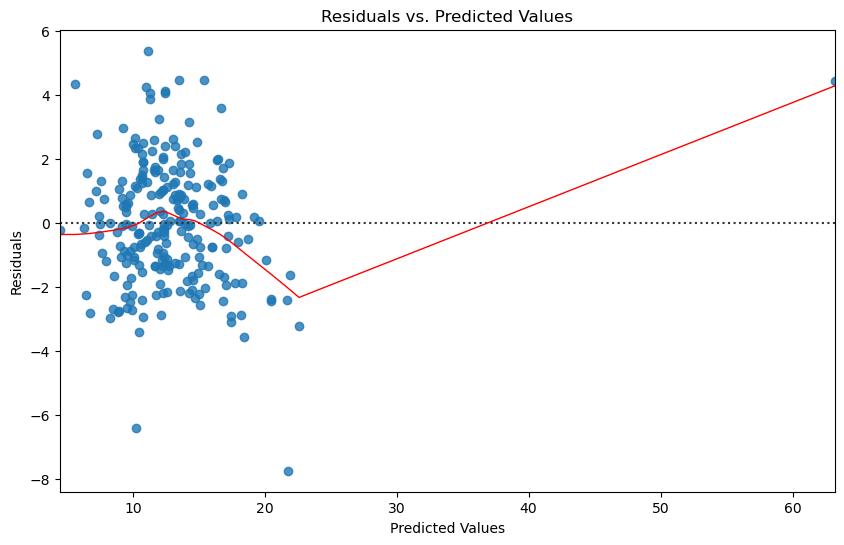

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correct usage of sns.residplot
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()


This plot should ideally show no discernible pattern; a random dispersion of residuals suggests that the model's assumptions are likely being met.

Checking for Normality of Residuals
We can use a Q-Q plot to visually check the normality of the residuals.

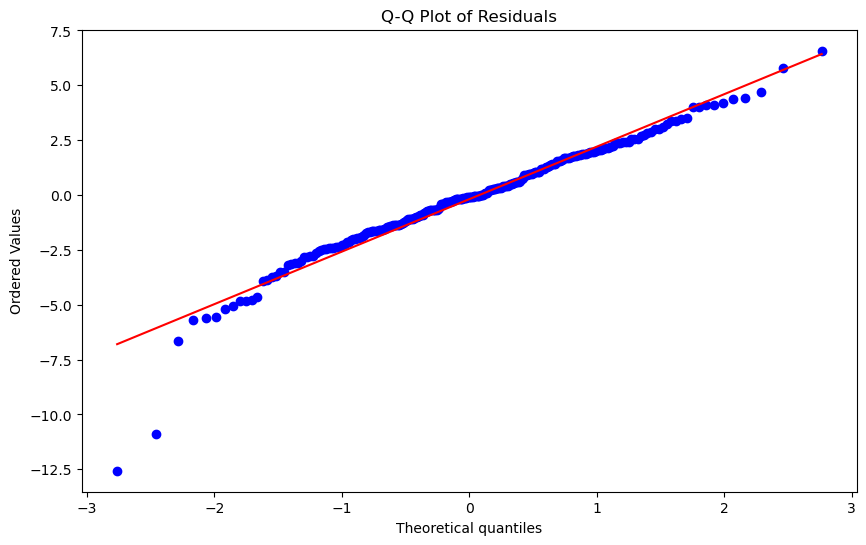

In [41]:
import scipy.stats as stats

plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()


A Q-Q plot that closely follows the 45-degree line suggests that the residuals are normally distributed.

In [48]:
from sklearn.model_selection import KFold
import statsmodels.api as sm
import numpy as np

# Prepare your data
X = sm.add_constant(X)  # Adds a constant term to the predictor variables
y = y

# Reset the index of X and y to ensure alignment
X_reset = X.reset_index(drop=True)
y_reset = y.reset_index(drop=True)

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = []

# Manually iterate over folds
for train_index, test_index in kf.split(X_reset):
    X_train, X_test = X_reset.iloc[train_index], X_reset.iloc[test_index]
    y_train, y_test = y_reset.iloc[train_index], y_reset.iloc[test_index]

    # Fit the model using statsmodels
    model = sm.OLS(y_train, X_train).fit()

    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Compute R² score
    # For models fitted with statsmodels, you'll need to calculate R² manually for the test set
    ss_res = np.sum((y_test - y_pred) ** 2)
    ss_tot = np.sum((y_test - np.mean(y_train)) ** 2)
    r2_score = 1 - (ss_res / ss_tot)

    r2_scores.append(r2_score)

# Calculate and print the average R² score
average_r2_score = np.mean(r2_scores)
print(f"R² scores for each fold: {r2_scores}")
print(f"Average R² across folds: {average_r2_score}")



R² scores for each fold: [0.5397836984382007, 0.4892371367555961, 0.6913961232814307, 0.5226715046208574, 0.2846430655666572]
Average R² across folds: 0.5055463057325484


In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, r2_score

# Define the model
model = RandomForestRegressor(random_state=42)

# Define the parameters grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Define the scorer
scorer = make_scorer(r2_score)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Fit to the data
grid_search.fit(X, y)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation R² score: {grid_search.best_score_}")


Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation R² score: 0.7548411615702196


max_depth: None (indicating no limit on the depth of the trees)
min_samples_split: 2 (the minimum number of samples required to split an internal node)
n_estimators: 50 (the number of trees in the forest)

In [51]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the RandomForestRegressor with the best parameters
optimal_model = RandomForestRegressor(max_depth=None, min_samples_split=2, n_estimators=50, random_state=42)

# Fit the model to your training data
optimal_model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=50, random_state=42)

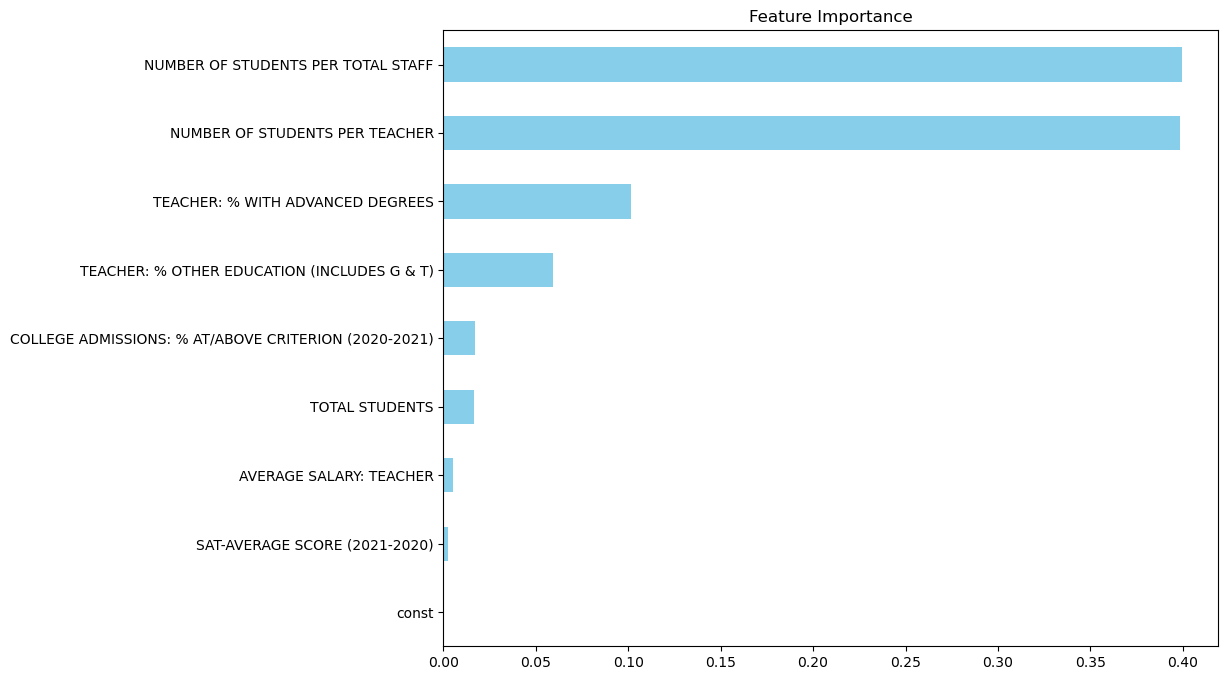

In [52]:
# Accessing feature importances
feature_importances = optimal_model.feature_importances_

# Assuming X_train is a DataFrame and we can get feature names
features = X_train.columns

# Plotting feature importances
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(feature_importances, index=features).sort_values()

plt.figure(figsize=(10,8))
importances.plot(kind='barh', color='skyblue')
plt.title('Feature Importance')
plt.show()


In [53]:
# Making predictions
y_pred = optimal_model.predict(X_test)

# Evaluate the model (example using R2 score)
from sklearn.metrics import r2_score

print("R2 Score:", r2_score(y_test, y_pred))


R2 Score: 0.8831618030746266
